Подключаем библиотеки и cuda

In [29]:
import os
import glob
import random

import torch
import numpy as np
import cv2

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import nn
from torchvision import transforms

import torch.nn.functional as F

In [30]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

device

'cuda'

Класс для датасета

In [31]:
class ColorDataset(Dataset):
    
    def __init__(self, rootdir, transform=None) -> None:
        super().__init__()
        self.class_names = os.listdir(rootdir)
        self.class_idx = [i for i in range(len(self.class_names))]
        self.transform = transform
        self.images_pathes = []
        self.images_clas_names = []

        for cls_name in self.class_names:
            sub_root = os.path.join(rootdir, cls_name)
            self.images_pathes.extend(glob.glob(os.path.join(sub_root, '*.jpg')))
            self.images_clas_names.append(cls_name)

        random.shuffle(self.images_pathes)
            
    def __len__(self):
        return len(self.images_pathes)
    
    def __getitem__(self, index) -> tuple:

        img_path = self.images_pathes[index]
        image = cv2.imread(img_path)
        img_folder_pth = os.path.split(img_path)[0]
        cls_name = os.path.split(img_folder_pth)[-1]
        label = self.class_names.index(cls_name)
        
        if self.transform:
            image = self.transform(image=image)["image"]

        return (image, label)

In [32]:
class TransformDataset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        
    def __getitem__(self, index):
        image, label = self.subset[index]
        if self.transform:
            image = self.transform(image=image)['image']
        return image, label
        
    def __len__(self):
        return len(self.subset)

In [33]:
transform = transforms.Compose(
    [
        transforms.ToTensor(), 
        transforms.Normalize(mean = 0.5, std = 0.5),
        # ToTensorV2()
    ]
    
)

In [34]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Нельзя применять цветовые аугментациии, задача завязна на цвете одежды

augmentation_transform = A.Compose([
    A.Flip(p=0.3),
    # A.ElasticTransform(alpha=1.15, sigma=50, alpha_affine=10),
    # A.RandomBrightnessContrast(p=0.4),
    A.Blur(blur_limit=3),
    A.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
    ToTensorV2()
])

default_transform = A.Compose([
    A.Normalize(mean=0.5, std=0.5),
    ToTensorV2()
])

Данные test хранятся в папке без деления на классы, что не даёт удобно проверить результаты. Для обучения данные разделим train на 2 набора train(80%) и test(20%).

In [35]:
import os

current_directory = os.getcwd()
DATA_PATH = os.path.join(current_directory, 'data')

In [36]:
classes = {n: cls for n,cls in enumerate(os.listdir(DATA_PATH))}
classes_invert = {value:key for key, value in classes.items() }

batch_size = 64
dataset = ColorDataset(DATA_PATH)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_modified_dataset = TransformDataset(train_dataset, default_transform)
test_modified_dataset = TransformDataset(test_dataset, default_transform)

train_loader = DataLoader(train_modified_dataset, batch_size=batch_size)
test_loader = DataLoader(test_modified_dataset, batch_size=batch_size)

In [37]:
for x,y in train_loader:
    print(x.shape)
    print(y)
    break

torch.Size([64, 3, 224, 224])
tensor([ 2,  9,  3,  8,  3,  0,  2,  0,  8,  8,  3, 10,  8,  2,  0,  1,  1,  3,
         6,  1,  4,  3,  9,  4,  0,  8, 10,  7,  3,  6, 10,  3,  2,  2,  9,  7,
         2,  3, 10,  9,  4,  1,  4,  3,  1,  3, 10,  1,  3,  5,  7, 10,  6,  4,
         2,  3,  8,  6,  1,  3,  4,  6,  7,  4])


In [38]:
# выход с последнего слоя
len(classes.values())       

12

In [39]:
class CSPBlock(nn.Module):
    '''
    Блок для снижения вычислительной сложности
    '''
    
    def __init__(self, input_channel):
        super(CSPBlock, self).__init__()
        self.conv_1 = nn.Conv2d(input_channel//2, input_channel//2, (1,1), 1, padding = 0)
        self.conv_3 = nn.Conv2d(input_channel//2, input_channel//2, (3,3), 1, padding = 1)

    def forward(self, x):
        in_chanel = x.size(1)
        #in_chanel = x.size()[2]
        x1 = x[:,:in_chanel//2, :, :]
        x2 = x[:,in_chanel//2:, :, :]
        x1 = self.conv_1(x1)
        x1 = F.relu(x1)
        x1 = self.conv_3(x1)
        x1 = F.relu(x1)
        x = torch.cat((x1, x2),dim=1)

        return x

Класс для модели

In [40]:
class ColorClassificator(nn.Module):
    def __init__(self):
        super(ColorClassificator, self).__init__()
        self.conv_1 = nn.Conv2d(3, 8, (2,2), 1)
        self.csp_1 = CSPBlock(8)
        self.conv_2 = nn.Conv2d(8, 16, (2,2), 1)
        self.conv_3 = nn.Conv2d(16, 32, (2,2), 1)
        self.csp_2 = CSPBlock(32)
        self.conv_4 = nn.Conv2d(32, 64, (2,2), 1)
        self.conv_5 = nn.Conv2d(64, 128, (2,2), 1)
        self.csp_3 = CSPBlock(128)
        self.conv_6 = nn.Conv2d(128, 256, (2,2), 1)
        
        self.pool = nn.MaxPool2d((2,2), 2)
        
        self.linear_1 = nn.Linear(173056, 512) # 26*26*256
        self.linear_2 = nn.Linear(512, 12)

    def forward(self, x):
        x = self.conv_1(x)
        x = F.relu(x)
        x = self.csp_1(x)
        x = self.conv_2(x)
        x = F.relu(x)
        x = self.pool(x)
        
        x = self.conv_3(x)
        x = F.relu(x)
        x = self.csp_2(x)
        x = self.conv_4(x)
        x = F.relu(x)
        x = self.pool(x)
        
        x = self.conv_5(x)
        x = F.relu(x)
        x = self.csp_3(x)
        x = self.conv_6(x)
        x = F.relu(x)
        x = self.pool(x)

        x = torch.flatten(x, start_dim=1)
        
        x = self.linear_1(x)
        x = F.relu(x)
        x = self.linear_2(x)
        
        return x

In [41]:
model = ColorClassificator()
model.to(device)
loss_function = torch.nn.CrossEntropyLoss()

optimizator = torch.optim.Adam(model.parameters(), lr=0.001,)

In [42]:
def val(model, test_loader):
    model.eval()
    tp = 0
    total = 0

    for x,y in test_loader:
        y = y.to(device)
        pred = torch.argmax(model(x.to(device)), dim=1)
        tp += int((pred == y).sum().to('cpu'))
        total +=len(pred)
    
    return tp/total

def train(dataloader, model, loss_fn, op_fn, epoch):
    for ep in range(epoch):
        for step, (x, y) in enumerate(dataloader):

            y_pred = model(x.to(device))
            loss = loss_fn(y_pred.to(device), y.to(device))

            op_fn.zero_grad()
            loss.backward()
            op_fn.step()

            if step%100 == 0:
                loss, current = loss.item(), (ep+1)*(step+1)*batch_size
                print(f"loss = {loss}, samples = {current}")

        acc = val(model, test_loader)
        print('accuracy', acc)

        torch.save(model, f'CNN_aug_color_classifier_{epoch}_epo_{acc}_acc.pt')

In [43]:
train(train_loader, model, loss_function, optimizator, 6)

loss = 2.4811079502105713, samples = 64
accuracy 0.21314102564102563
loss = 2.078855037689209, samples = 128
accuracy 0.3525641025641026
loss = 1.6085313558578491, samples = 192
accuracy 0.4719551282051282
loss = 1.2706760168075562, samples = 256
accuracy 0.5240384615384616
loss = 1.1562021970748901, samples = 320
accuracy 0.5737179487179487
loss = 0.9860660433769226, samples = 384
accuracy 0.592948717948718


In [44]:
model(x.cuda()).size()

torch.Size([64, 12])

Рассчёт метрик

In [45]:
model.eval()

ColorClassificator(
  (conv_1): Conv2d(3, 8, kernel_size=(2, 2), stride=(1, 1))
  (csp_1): CSPBlock(
    (conv_1): Conv2d(4, 4, kernel_size=(1, 1), stride=(1, 1))
    (conv_3): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (conv_2): Conv2d(8, 16, kernel_size=(2, 2), stride=(1, 1))
  (conv_3): Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1))
  (csp_2): CSPBlock(
    (conv_1): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1))
    (conv_3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (conv_4): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1))
  (conv_5): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1))
  (csp_3): CSPBlock(
    (conv_1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (conv_3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (conv_6): Conv2d(128, 256, kernel_size=(2, 2), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear_1): L

In [46]:
def calculate_metrics(model, data_loader, device):
    
    '''
    Функция для рассчёта метрик 
    Accuracy, Recall, Precision
    
    Вход: model, data_loader, device
    Выход: значения метрик accuracy, precision, recall
    '''
    
    correct_predictions = 0
    total_predictions = 0
    num_classes = len(classes.values())

    true_positives = [0] * num_classes
    false_positives = [0] * num_classes
    false_negatives = [0] * num_classes

    for data in data_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        _, predicts = torch.max(model(inputs), 1)  # Получаем классы с максимальной вероятностью
                    
        total_predictions += labels.size(0)
        correct_predictions += (predicts == labels).sum().item()
        
        for i in range(len(labels)):
            if predicts[i] == labels[i]:
                true_positives[labels[i].item()] += 1
            else:
                false_positives[predicts[i].item()] += 1
                false_negatives[labels[i].item()] += 1
                
        recall, precision = 0, 0
                
        for i in range(num_classes):
            if (true_positives[i] + false_positives[i]) > 0:
                precision += true_positives[i] / (true_positives[i] + false_positives[i])
    
            if (true_positives[i] + false_negatives[i]) > 0:
                recall += true_positives[i] / (true_positives[i] + false_negatives[i]) 

        accuracy = correct_predictions / total_predictions
        precision /= num_classes
        recall /= num_classes
    
    return accuracy, precision, recall


In [47]:
model.to(device)
accuracy, precision, recall = calculate_metrics(model, test_loader, device)

print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'Precision: {precision * 100:.2f}%')
print(f'Recall: {recall * 100:.2f}%')

Accuracy: 59.29%
Precision: 54.85%
Recall: 54.50%


In [49]:
predicts = []
labels = []

for x,y in test_loader:
    y = y.to('cpu').numpy()
    pred = torch.argmax(model(x.to(device)), dim=1).to('cpu').numpy()
    predicts.append(pred)
    labels.append(y)

print(len(predicts))

20


In [50]:
predicts = np.concatenate(predicts)
labels = np.concatenate(labels)

In [51]:
from sklearn.metrics import confusion_matrix

In [52]:
model.to("cpu")
cm = confusion_matrix(labels, predicts, labels=tuple(classes.keys()))

In [53]:
cm.shape

(12, 12)

<Figure size 20000x20000 with 0 Axes>

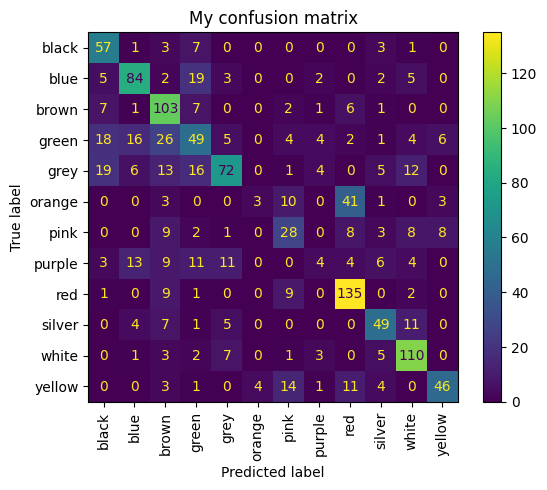

In [54]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

plt.figure(figsize=(200,200))
cm = confusion_matrix(labels, predicts, labels=tuple(classes.keys()))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=tuple(classes.values()))
disp.plot()
plt.title("My confusion matrix")
plt.xticks(rotation=90)
plt.show()